In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json
from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
import subprocess
import dask
from dask.distributed import Client
import timeit

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [2]:
def remove_small_contours(p, thres=10):
    for level in p.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            # go in reversed order due to deletions!

            # include test for "smallness" of your choice here:
            # I'm using a simple estimation for the diameter based on the
            #    x and y diameter...
            verts = path.vertices # (N,2)-shape array of contour line coordinates
            diameter = np.max(verts.max(axis=0) - verts.min(axis=0))

            if diameter<thres: # threshold to be refined for your actual dimensions!
                del(level.get_paths()[kp])  # no remove() for Path objects:(


In [3]:
def get_figure_init_times(fig_dir):
    # Get list of all figures
    fig_files = glob.glob(os.path.join(fig_dir,'*.png'))
    init_times = list(reversed(sorted(list(set([os.path.basename(x).split('_')[3] for x in fig_files])))))
    return init_times

In [4]:
# get_figure_init_times( os.path.join(ed.EsioData.load().fig_dir, 'model', 'all_model', 'sic', 'maps_weekly'))

In [5]:
def update_status(ds_status=None, fig_dir=None, int_2_days_dict=None, NweeksUpdate=3):
    # Get list of all figures
    fig_files = glob.glob(os.path.join(fig_dir,'*.png'))
    # For each figure
    for fig_f in fig_files:
        # Get the init_time from file name
        cit = os.path.basename(fig_f).split('_')[3]
        # Get the forecast int from file name
        cft = int(os.path.basename(fig_f).split('_')[4].split('.')[0])
        # Check if current it and ft were requested, otherwise skip
        if (np.datetime64(cit) in ds_status.init_time.values) & (np.timedelta64(int_2_days_dict[cft]) in ds_status.fore_time.values):
            # Always update the last 3 weeks (some models have lagg before we get them)
            # Check if cit is one of the last NweeksUpdate init times in init_time
            if (np.datetime64(cit) not in ds_status.init_time.values[-NweeksUpdate:]):
                ds_status.status.loc[dict(init_time=cit, fore_time=int_2_days_dict[cft])] = 1
        
    return ds_status

In [6]:
def Update_PanArctic_Maps():
    # Plotting Info
    runType = 'forecast'
    variables = ['sic']
    metrics_all = {'sic':['anomaly','mean','SIP'], 'hi':['mean']}
    #metrics_all = {'sic':['SIP']}
    updateAll = False
    # Some models are terrible/have serious issues, so don't include in MME
    MME_NO = ['hcmr']

    # Define Init Periods here, spaced by 7 days (aprox a week)
    # Now
    cd = datetime.datetime.now()
    cd = datetime.datetime(cd.year, cd.month, cd.day) # Set hour min sec to 0. 
    # Hardcoded start date (makes incremental weeks always the same)
    start_t = datetime.datetime(1950, 1, 1) # datetime.datetime(1950, 1, 1)
    # Parms for this plot
    Ndays = 7 # time period to aggregate maps to
    Npers = 14 # number of periods to plot (from current date)
    init_slice = np.arange(start_t, cd, datetime.timedelta(days=Ndays)).astype('datetime64[ns]')
    init_slice = init_slice[-Npers:] # Select only the last Npers of periods (weeks) since current date

    # Forecast times to plot
    weeks = pd.to_timedelta(np.arange(0,5,1), unit='W')
    months = pd.to_timedelta(np.arange(2,12,1), unit='M')
    years = pd.to_timedelta(np.arange(1,2), unit='Y') - np.timedelta64(1, 'D') # need 364 not 365
    slices = weeks.union(months).union(years).round('1d')
    da_slices = xr.DataArray(slices, dims=('fore_time'))
    da_slices.fore_time.values.astype('timedelta64[D]')
    print(da_slices)

    # Help conversion between "week/month" period used for figure naming and the actual forecast time delta value
    int_2_days_dict = dict(zip(np.arange(0,da_slices.size), da_slices.values))
    days_2_int_dict = {v: k for k, v in int_2_days_dict.items()}

    #############################################################
    # Load in Data
    #############################################################

    E = ed.EsioData.load()
    # Get median ice edge by DOY
    median_ice_fill = xr.open_mfdataset(os.path.join(E.obs_dir, 'NSIDC_0051', 'agg_nc', 'ice_edge.nc')).sic
    # Get mean sic by DOY
    mean_1980_2010_sic = xr.open_dataset(os.path.join(E.obs_dir, 'NSIDC_0051', 'agg_nc', 'mean_1980_2010_sic.nc')).sic
    # Get average sip by DOY
    mean_1980_2010_SIP = xr.open_dataset(os.path.join(E.obs_dir, 'NSIDC_0051', 'agg_nc', 'hist_SIP_1980_2010.nc')).sip    
    
    # Get current observations
    ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True)#,

    # Define models to plot
    models_2_plot = list(E.model.keys())
    models_2_plot = [x for x in models_2_plot if x!='piomas'] # remove some models
    models_2_plot = [x for x in models_2_plot if E.icePredicted[x]] # Only predictive models

    # Get # of models and setup subplot dims
    Nmod = len(models_2_plot) + 2 #(+2 for obs and MME)
    Nr = int(np.floor(np.sqrt(Nmod)))
    Nc = int(np.ceil(Nmod/Nr))
    assert Nc*Nr>=Nmod, 'Need more subplots'

    for cvar in variables:

        # Define fig dir and make if doesn't exist
        fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, 'maps_weekly')
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)

        # Make requested dataArray as specified above
        ds_status = xr.DataArray(np.ones((init_slice.size, da_slices.size))*np.NaN, dims=('init_time','fore_time'), coords={'init_time':init_slice,'fore_time':da_slices}) 
        ds_status.name = 'status'
        ds_status = ds_status.to_dataset()

        # Check what plots we already have
        if not updateAll:
            print("Removing figures we have already made")
            ds_status = update_status(ds_status=ds_status, fig_dir=fig_dir, int_2_days_dict=int_2_days_dict)
            
        print(ds_status.status.values)
        # Drop IC/FT we have already plotted (orthoginal only)
        ds_status = ds_status.where(ds_status.status.sum(dim='fore_time')<ds_status.fore_time.size, drop=True)
        
        print("Starting plots...")
        # For each init_time we haven't plotted yet
        start_time_cmod = timeit.default_timer()
        for it in ds_status.init_time.values: 
            print(it)
            it_start = it-np.timedelta64(Ndays,'D') # Start period for init period (it is end of period)

            # For each forecast time we haven't plotted yet
            ft_to_plot = ds_status.sel(init_time=it)
            ft_to_plot = ft_to_plot.where(ft_to_plot.isnull(), drop=True).fore_time
            for ft in ft_to_plot.values: 
                print(ft.astype('timedelta64[D]'))
                cs_str = format(days_2_int_dict[ft], '02')
                week_str = format(int(ft.astype('timedelta64[D]').astype('int')/Ndays) , '02')
                cdoy_end = pd.to_datetime(it + ft).timetuple().tm_yday
                cdoy_start = pd.to_datetime(it_start + ft).timetuple().tm_yday
                it_yr = str(pd.to_datetime(it).year)
                it_m = str(pd.to_datetime(it).month)

                # Get datetime64 of valid time start and end
                valid_start = it_start + ft
                valid_end = it + ft

                # Loop through variable of interest + any metrics (i.e. SIP) based on that
                for metric in metrics_all[cvar]:

                    # Set up plotting info
                    if cvar=='sic':
                        if metric=='mean':
                            cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
                            cmap_c.set_bad(color = 'lightgrey')
                            c_label = 'Sea Ice Concentration (-)'
                            c_vmin = 0
                            c_vmax = 1
                        elif metric=='SIP':
                            cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"])
                            cmap_c.set_bad(color = 'lightgrey')
                            c_label = 'Sea Ice Probability (-)'
                            c_vmin = 0
                            c_vmax = 1
                        elif metric=='anomaly':
    #                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
                            cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
                            cmap_c.set_bad(color = 'lightgrey')
                            c_label = 'SIC Anomaly to 1980-2010 Mean'
                            c_vmin = -1
                            c_vmax = 1

                    elif cvar=='hi':
                        if metric=='mean':
                            cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
                            cmap_c.set_bad(color = 'lightgrey')
                            c_label = 'Sea Ice Thickness (m)'
                            c_vmin = 0
                            c_vmax = None
                    else:
                        raise ValueError("cvar not found.") 


                    MME_list = []            
                    # New Plot
                    start_time_plot = timeit.default_timer()
                    (f, axes) = ice_plot.multi_polar_axis(ncols=Nc, nrows=Nr, Nplots=Nmod)

                    # Plot Obs (if available)
                    ax_num = 0
                    #ds_model = ds_model.sel(init_time=slice(it_start, it))
                    da_obs_c = ds_81.sic.sel(time=slice(valid_start,valid_end))
                    # Check we found any times in target valid time range
                    if da_obs_c.time.size>0:
                    #if ((it + ft) in ds_81.time.values):

                        if metric=='mean':
                            da_obs_c = da_obs_c.mean(dim='time') #ds_81.sic.sel(time=(it + ft))
                        elif metric=='SIP':
                            da_obs_c = (da_obs_c >= 0.15).mean(dim='time').astype('int').where(da_obs_c.isel(time=0).notnull())
                        elif metric=='anomaly':
                            da_obs_VT = da_obs_c.mean(dim='time')
                            da_obs_mean = mean_1980_2010_sic.isel(time=slice(cdoy_start,cdoy_end)).mean(dim='time')
                            da_obs_c = da_obs_VT - da_obs_mean
                        else:
                            raise ValueError('Not implemented')
                        da_obs_c.plot.pcolormesh(ax=axes[ax_num], x='lon', y='lat', 
                                              transform=ccrs.PlateCarree(),
                                              add_colorbar=False,
                                              cmap=cmap_c,
                                              vmin=c_vmin, vmax=c_vmax)
                        axes[ax_num].set_title('Observed')
                        # Overlay median ice edge
                        #if metric=='mean':
                            #po = median_ice_fill.isel(time=cdoy).plot.contour(ax=axes[ax_num], x='xm', y='ym', 
                                                                              #=('#bc0f60'),
                                                                              #linewidths=[0.5],
                                                                              #levels=[0.5])
                            #remove_small_contours(po, thres=10)
                    else: # When were in the future (or obs are missing)
                        if metric=='anomaly': # Still get climatological mean for model difference
                            da_obs_mean = mean_1980_2010_sic.isel(time=slice(cdoy_start,cdoy_end)).mean(dim='time')
                        elif metric=='SIP': # Plot this historical mean SIP 
                            da_obs_c = mean_1980_2010_SIP.isel(time=slice(cdoy_start,cdoy_end)).mean(dim='time')
                            da_obs_c.plot.pcolormesh(ax=axes[ax_num], x='lon', y='lat', 
                              transform=ccrs.PlateCarree(),
                              add_colorbar=False,
                              cmap=cmap_c,
                              vmin=c_vmin, vmax=c_vmax)
                            axes[ax_num].set_title('Hist. Obs.')


                    # Plot all Models
                    p = None # initlaize to know if we found any data
                    for (i, cmod) in enumerate(models_2_plot):
                        print(cmod)
                        i = i+2 # shift for obs and MME
                        axes[i].set_title(E.model[cmod]['model_label'])

                        # Load in Model
                        # Find only files that have current year and month in filename (speeds up loading)
                        all_files = os.path.join(E.model[cmod][runType]['sipn_nc'], '*'+it_yr+'*'+it_m+'*.nc') 

                        # Check we have files 
                        files = glob.glob(all_files)
                        if not files:
                            #print("Skipping model", cmod, "no forecast files found.")
                            continue # Skip this model

                        # Load in model    
                        #start_time = timeit.default_timer()
                        ds_model = xr.open_mfdataset(sorted(files), 
                                                     chunks={'fore_time': 1, 'init_time': 1, 'nj': 304, 'ni': 448},  
                                                     concat_dim='init_time', autoclose=True, parallel=True)
                        ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)
                        #print("Loading took  ", (timeit.default_timer() - start_time), " seconds.")

                        # Select init period and fore_time of interest
                        #start_time = timeit.default_timer()
                        ds_model = ds_model.sel(init_time=slice(it_start, it))
                        # Check we found any init_times in range
                        if ds_model.init_time.size==0:
                            print('init_time not found.')
                            continue
                        #print("Selecting init_time took  ", (timeit.default_timer() - start_time), " seconds.")

                        # Select var of interest (if available)
                        if cvar in ds_model.variables:
        #                     print('found ',cvar)
                            ds_model = ds_model[cvar]
                        else:
                            print('cvar not found.')
                            continue

                        #start_time = timeit.default_timer()
                        # Get Valid time
                        ds_model = import_data.get_valid_time(ds_model)

                        # Check if we have any valid times in range of target dates
                        ds_model = ds_model.where((ds_model.valid_time>=valid_start) & (ds_model.valid_time<=valid_end), drop=True) 
                        if ds_model.fore_time.size == 0:
                            print("no fore_time found for target period.")
                            continue

                        # Average over for_time and init_times
                        ds_model = ds_model.mean(dim=['fore_time','init_time'])

    #                     if ft in ds_model.fore_time.values:
    #                         ds_model = ds_model.sel(fore_time=ft)
    #                     else:
    #                         print('fore_time not found.')
    #                         continue
                        #print("Selecting fore_time took ", (timeit.default_timer() - start_time), " seconds.")

                        #start_time = timeit.default_timer()
        #                 print("Found data for model ", cmod, ". Plotting...")    
                        if metric=='mean': # Calc ensemble mean
                            ds_model = ds_model.mean(dim='ensemble')
                        elif metric=='SIP': # Calc probability
                            # Issue of some ensemble members having missing data
    #                         ds_model = ds_model.where(ds_model>=0.15, other=0).mean(dim='ensemble')
                            ok_ens = ((ds_model.notnull().sum(dim='x').sum(dim='y'))>0) # select ensemble members with any data
                            ds_model = ((ds_model.where(ok_ens, drop=True)>=0.15) ).mean(dim='ensemble').where(ds_model.isel(ensemble=0).notnull())
                        elif metric=='anomaly': # Calc anomaly in reference to mean observed 1980-2010
                            ds_model = ds_model.mean(dim='ensemble') - da_obs_mean
                            # Add back lat/long (get dropped because of round off differences)
                            ds_model['lat'] = da_obs_mean.lat
                            ds_model['lon'] = da_obs_mean.lon
                        else:
                            raise ValueError('metric not implemented')
                        #print("Calc metric took  ", (timeit.default_timer() - start_time), " seconds.")

                        # Build MME
                        if 'ensemble' in ds_model:
                            ds_model = ds_model.drop('ensemble')
                        if cmod not in MME_NO: # Exclude some models (bad) from MME
                            MME_list.append(ds_model)

                        # Plot
                        #start_time = timeit.default_timer()
                        p = ds_model.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                              transform=ccrs.PlateCarree(),
                                              add_colorbar=False,
                                              cmap=cmap_c,
                                              vmin=c_vmin, vmax=c_vmax)
                        #print("Plotting took  ", (timeit.default_timer() - start_time), " seconds.")

                        # Overlay median ice edge
                        #if metric=='mean':
                            #po = median_ice_fill.isel(time=cdoy).plot.contour(ax=axes[i], x='xm', y='ym', 
                                                                              #colors=('#bc0f60'),
                                                                              #linewidths=[0.5],
                                                                              #levels=[0.5]) #, label='Median ice edge 1981-2010')
                            #remove_small_contours(po, thres=10)

                        axes[i].set_title(E.model[cmod]['model_label'])

                        # Clean up for current model
                        ds_model = None



                    # MME
                    ax_num = 1
                    if MME_list: # If we had any models for this time
                        # Concat over all models
                        ds_MME = xr.concat(MME_list, dim='model')
                        # Take average
                        ds_MME = ds_MME.mean(dim='model')
                        # Mask out using OBSERVED LAND MASK
                        # TODO: should happen if all models have land mask.... fix upstream
                        pmme = ds_MME.plot.pcolormesh(ax=axes[ax_num], x='lon', y='lat', 
                                                      transform=ccrs.PlateCarree(),
                                                      add_colorbar=False, 
                                                      cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
                        # Overlay median ice edge
                        #if metric=='mean':
                            #po = median_ice_fill.isel(time=cdoy).plot.contour(ax=axes[ax_num], x='xm', y='ym', 
    #                                                                           colors=('#bc0f60'),
    #                                                                           linewidths=[0.5],
    #                                                                           levels=[0.5])
                            #remove_small_contours(po, thres=10)
                    axes[ax_num].set_title('MME')

                    # Make pretty
                    f.subplots_adjust(right=0.8)
                    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
                    if p:
                        cbar = f.colorbar(p, cax=cbar_ax, label=c_label)
                        if metric=='anomaly':
                            cbar.set_ticks(np.arange(-1,1.1,0.2))
                        else:
                            cbar.set_ticks(np.arange(0,1.1,0.1))
                        #cbar.set_ticklabels(np.arange(0,1,0.05))

                    # Set title of all plots
                    init_time_2 =  pd.to_datetime(it).strftime('%Y-%m-%d')
                    init_time_1 =  pd.to_datetime(it_start).strftime('%Y-%m-%d')
                    valid_time_2 = pd.to_datetime(it+ft).strftime('%Y-%m-%d')
                    valid_time_1 = pd.to_datetime(it_start+ft).strftime('%Y-%m-%d')
                    plt.suptitle('Initialization Time: '+init_time_1+' to '+init_time_2+'\n Valid Time: '+valid_time_1+' to '+valid_time_2,
                                 fontsize=15) # +'\n Week '+week_str
                    plt.subplots_adjust(top=0.85)

                    # Save to file
                    f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+init_time_2+'_'+cs_str+'.png')
                    f.savefig(f_out,bbox_inches='tight', dpi=200)
                    print("saved ", f_out)
                    print("Figure took  ", (timeit.default_timer() - start_time_plot)/60, " minutes.")

                    # Mem clean up
                    plt.close(f)
                    p = None
                    ds_MME= None
                    da_obs_c = None
                    da_obs_mean = None

            # Done with current it
            print("Took ", (timeit.default_timer() - start_time_cmod)/60, " minutes.")

    # Down with plots now:
    # 1) Update json file
    # 2) Update gifs

#     # Make requested dataArray as specified above
#     ds_status = xr.DataArray(np.ones((init_slice.size, da_slices.size))*np.NaN, dims=('init_time','fore_time'), coords={'init_time':init_slice,'fore_time':da_slices}) 
#     ds_status.name = 'status'
#     ds_status = ds_status.to_dataset()

#     # Check what plots we already have
#     if ~updateAll:
#         ds_status = update_status(ds_status=ds_status, fig_dir=fig_dir, int_2_days_dict=int_2_days_dict)
#         print(ds_status.status.values)


    json_format = get_figure_init_times(fig_dir)
    json_dict = [{"date":cd,"label":cd} for cd in json_format]

    json_f = os.path.join(fig_dir, 'plotdates_current.json')
    with open(json_f, 'w') as outfile:
        json.dump(json_dict, outfile)

    # Make into Gifs
    # TODO fig_dir hardcoded to current variable
    for cit in json_format:
        subprocess.call(str("/home/disk/sipn/nicway/python/ESIO/scripts/makeGif.sh " + fig_dir + " " + cit), shell=True)

    print("Finished plotting panArctic Maps.")

<xarray.DataArray (fore_time: 16)>
array([                0,   604800000000000,  1209600000000000,
        1814400000000000,  2419200000000000,  5270400000000000,
        7862400000000000, 10540800000000000, 13132800000000000,
       15811200000000000, 18403200000000000, 20995200000000000,
       23673600000000000, 26265600000000000, 28944000000000000,
       31449600000000000], dtype='timedelta64[ns]')
Coordinates:
  * fore_time  (fore_time) timedelta64[ns] 0 days 7 days 14 days 21 days ...
Removing figures we have already made
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 7390 was killed by unknown signal
distributed.nanny - WARNING - Worker process 7377 was killed by unknown signal
distributed.nann

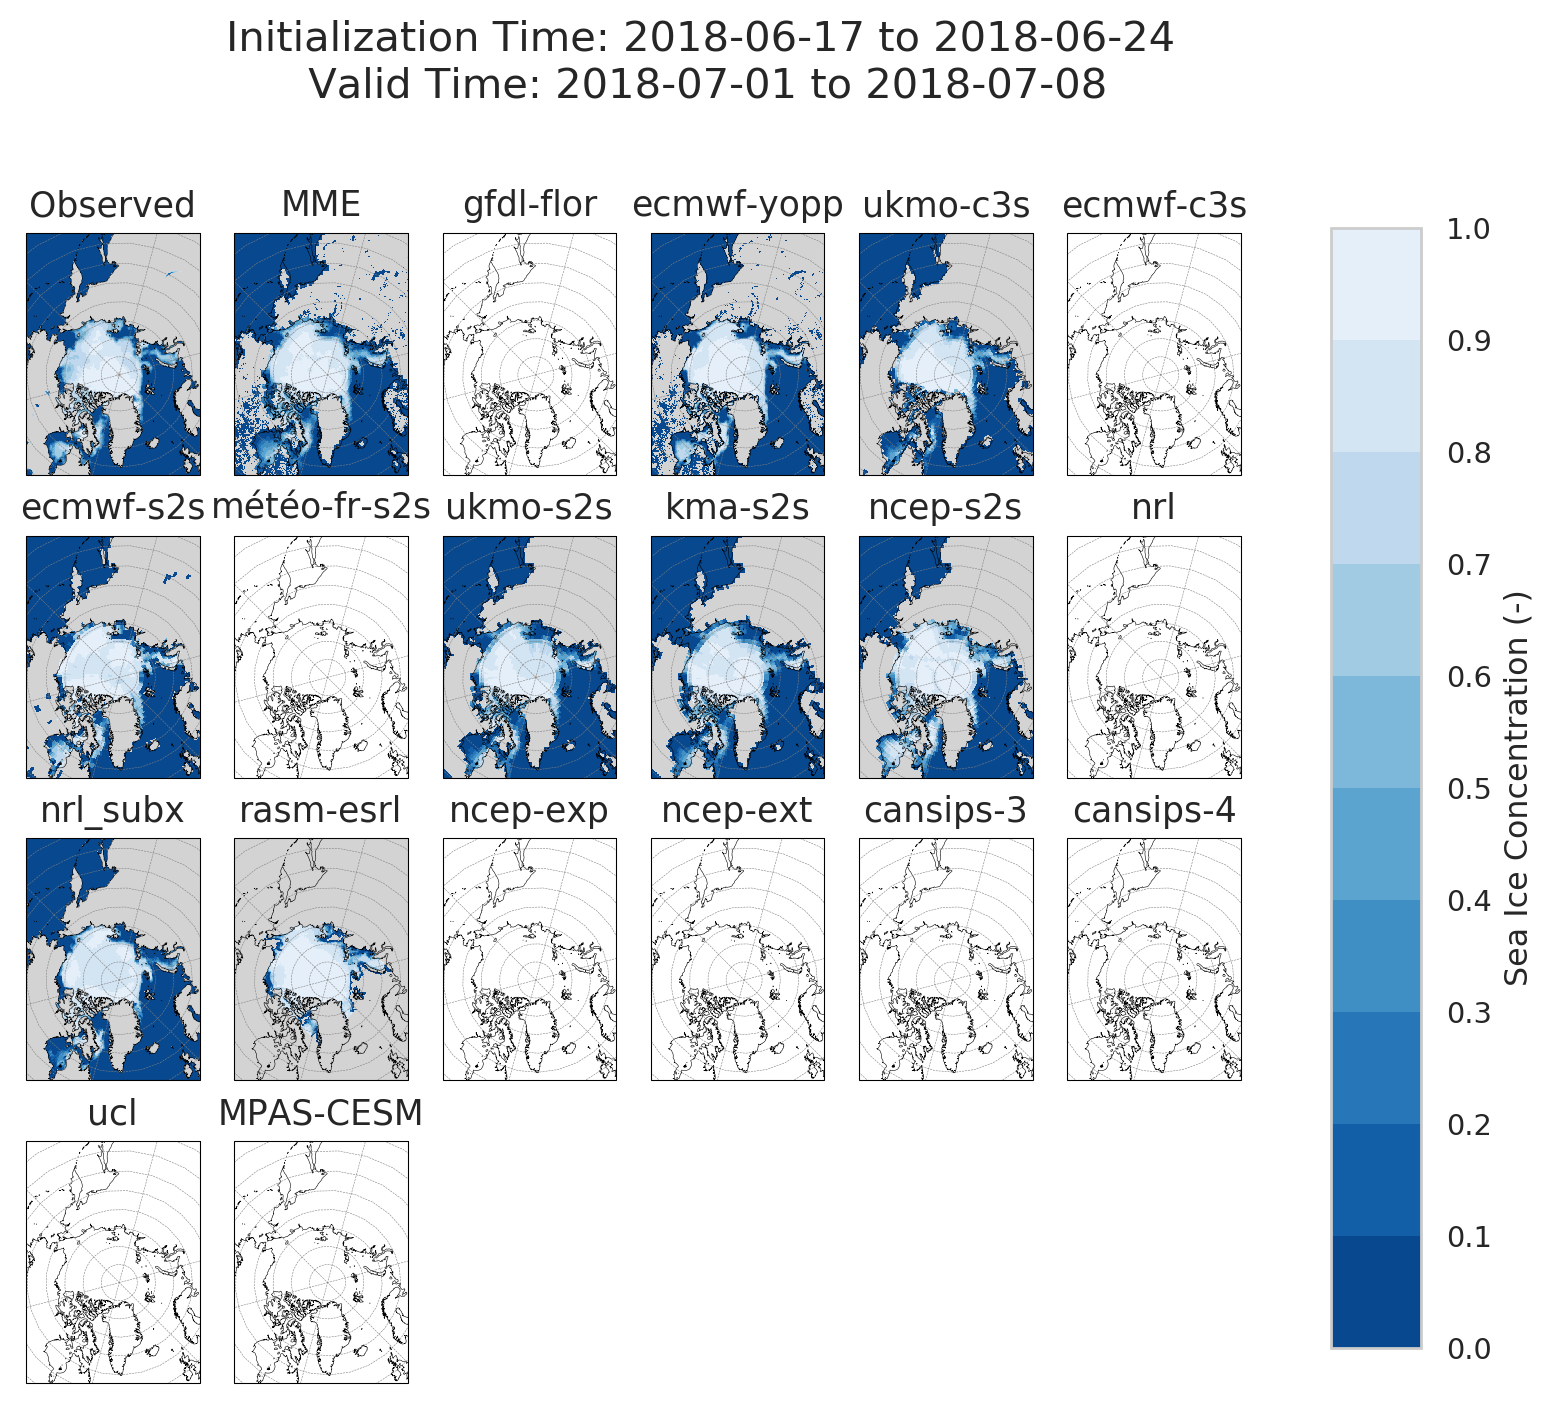

In [7]:
if __name__ == '__main__':
    # Start up Client
    client = Client()
    
    # Call function
    Update_PanArctic_Maps()

In [ ]:
# # Run below in case we need to just update the json file and gifs


# fig_dir = '/home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly'
# json_format = get_figure_init_times(fig_dir)
# json_dict = [{"date":cd,"label":cd} for cd in json_format]

# json_f = os.path.join(fig_dir, 'plotdates_current.json')
# with open(json_f, 'w') as outfile:
#     json.dump(json_dict, outfile)

# # Make into Gifs
# # TODO fig_dir hardcoded to current variable
# for cit in json_format:
#     subprocess.call(str("/home/disk/sipn/nicway/python/ESIO/scripts/makeGif.sh " + fig_dir + " " + cit), shell=True)

# print("Finished plotting panArctic Maps.")